# Run a batch of samples

In [195]:
!conda list | grep covid19sim

In [ ]:
#!ansible-playbook /src/ansible/playbooks/covid19sim.yml

In [ ]:
!ls -ltr params

In [ ]:
!ls /COVI-AgentSim/src/covid19sim/configs/simulation/region

I had uploaded the latest and greatest draft parameter file to a github repo. Maybe could have pulled it directoy from kingston-params repo (if I had saved it there--maybe a better place to save versions of parameter sets for the moment than directly in the experiment repo)

In [ ]:
!cp params/kingston_0xdfc056a4fdb804e60e964b2cc5aae6ea.yml /COVI-AgentSim/src/covid19sim/configs/simulation/region/kingston0xdfc056a4fdb804e60e964b2cc5aae6ea.yaml

In [ ]:
!ls /COVI-AgentSim/src/covid19sim/configs/simulation/region

In [ ]:
!ls -ltr /src/experiments/validation/results/data

In [82]:
from numpy.random import default_rng

rng = default_rng()

seed_list = [rng.integers(low=0, high=1e4) for _ in range(2)]

len(seed_list), seed_list[0:10]

(2, [189, 3511])

In [66]:
import numpy as np

len(np.unique(seed_list))

8

In [ ]:
!conda install pandas -y

In [ ]:
!conda install jupyter -y

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

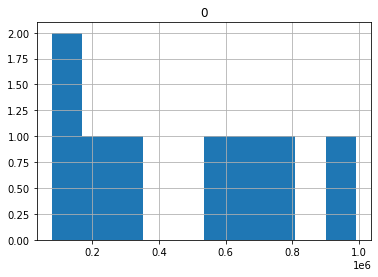

In [3]:
import pandas as pd

pd.DataFrame(seed_list).hist()

In [92]:
args_dict = {'region': 'kingston0xdfc056a4fdb804e60e964b2cc5aae6ea',
        'n_people': 3000,
        'simulation_days': 60,
        'init_fraction_sick': 0.002,
        'N_BEHAVIOR_LEVELS': 2,
        'intervention': 'no_intervention',
        'tune': True,
        'track': 'light',
        'GLOBAL_MOBILITY_SCALING_FACTOR': 0.85,
        'APP_UPTAKE': -1,
        'USE_INFERENCE_SERVER': False,
        'INTERVENTION_DAY': -1}
args_dict

{'region': 'kingston0xdfc056a4fdb804e60e964b2cc5aae6ea',
 'n_people': 3000,
 'simulation_days': 60,
 'init_fraction_sick': 0.002,
 'N_BEHAVIOR_LEVELS': 2,
 'intervention': 'no_intervention',
 'tune': True,
 'track': 'light',
 'GLOBAL_MOBILITY_SCALING_FACTOR': 0.85,
 'APP_UPTAKE': -1,
 'USE_INFERENCE_SERVER': False,
 'INTERVENTION_DAY': -1}

In [93]:
args_str = ' '.join([f'{k}={v}' for k, v in args_dict.items()])
args_str

'region=kingston0xdfc056a4fdb804e60e964b2cc5aae6ea n_people=3000 simulation_days=60 init_fraction_sick=0.002 N_BEHAVIOR_LEVELS=2 intervention=no_intervention tune=True track=light GLOBAL_MOBILITY_SCALING_FACTOR=0.85 APP_UPTAKE=-1 USE_INFERENCE_SERVER=False INTERVENTION_DAY=-1'

In [99]:
import random
import subprocess

run_id = hex(random.getrandbits(128))

args_list = [f'python /COVI-AgentSim/src/covid19sim/run.py seed={s} outdir=/src/experiments/validation/results/data/{run_id} {args_str}\n' for s in seed_list]

file_name = f'val-1-{run_id}'

with open(file_name, 'w') as arg_file:
    arg_file.writelines(args_list)
    
subprocess.run(f'cat {file_name} | parallel -j4', shell=True, capture_output=True)

file_name

'val-1-0x323219c230079382f2af0c132c1e4294'

In [104]:
!ls /src/experiments/validation/results/data/0x323219c230079382f2af0c132c1e4294/*/*tracker*

/src/experiments/validation/results/data/0x323219c230079382f2af0c132c1e4294/sim_v2_people-3000_days-60_init-0.002_uptake--1_seed-189_20210703-151918_225800/tracker_data_n_3000_seed_189_20210703-152928.pkl
/src/experiments/validation/results/data/0x323219c230079382f2af0c132c1e4294/sim_v2_people-3000_days-60_init-0.002_uptake--1_seed-3511_20210703-151918_587200/tracker_data_n_3000_seed_3511_20210703-152926.pkl


In [123]:
r = subprocess.run(f'ls /src/experiments/validation/results/data/0x323219c230079382f2af0c132c1e4294/*/*tracker*', shell=True, capture_output=True)
r.stdout

b'/src/experiments/validation/results/data/0x323219c230079382f2af0c132c1e4294/sim_v2_people-3000_days-60_init-0.002_uptake--1_seed-189_20210703-151918_225800/tracker_data_n_3000_seed_189_20210703-152928.pkl\n/src/experiments/validation/results/data/0x323219c230079382f2af0c132c1e4294/sim_v2_people-3000_days-60_init-0.002_uptake--1_seed-3511_20210703-151918_587200/tracker_data_n_3000_seed_3511_20210703-152926.pkl\n'

In [145]:
import os

samples = os.listdir(f'./results/data/{run_id}')
samples

['sim_v2_people-3000_days-60_init-0.002_uptake--1_seed-189_20210703-151918_225800',
 'sim_v2_people-3000_days-60_init-0.002_uptake--1_seed-3511_20210703-151918_587200']

In [152]:
data = [os.listdir(f'./results/data/{run_id}/{s}') for s in samples]
data_df = pd.DataFrame(data, columns=['params', 'log', 'metrics'])
data_df['sample'] = samples
data_df

,params,log,metrics,sample
0,full_configuration.yaml,log_20210703-151918.txt,tracker_data_n_3000_seed_189_20210703-152928.pkl,sim_v2_people-3000_days-60_init-0.002_uptake--...
1,full_configuration.yaml,log_20210703-151918.txt,tracker_data_n_3000_seed_3511_20210703-152926.pkl,sim_v2_people-3000_days-60_init-0.002_uptake--...


In [188]:
cases_list = []
i=0
for _, data in data_df.iterrows():
    with open(f'/src/experiments/validation/results/data/{run_id}/{data["sample"]}/{data["metrics"]}', 'rb') as tracker:
        tracker_dict = pickle.load(tracker)
        cases_list.append(pd.DataFrame(tracker_dict['cases_per_day'], columns=[i]))
        i += 1
cases_df = pd.concat(cases_list, axis=1)
cases_df

,0,1
0,6,6
1,0,0
2,1,1
3,3,2
4,6,0
5,5,3
6,2,3
7,12,19
8,1,1
9,1,0


In [192]:
cases_df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,6,0,1,3,6,5,2,12,1,1,...,5,3,29,20,22,18,14,4,2,13
1,6,0,1,2,0,3,3,19,1,0,...,9,3,22,18,26,20,13,4,2,18


<AxesSubplot:>

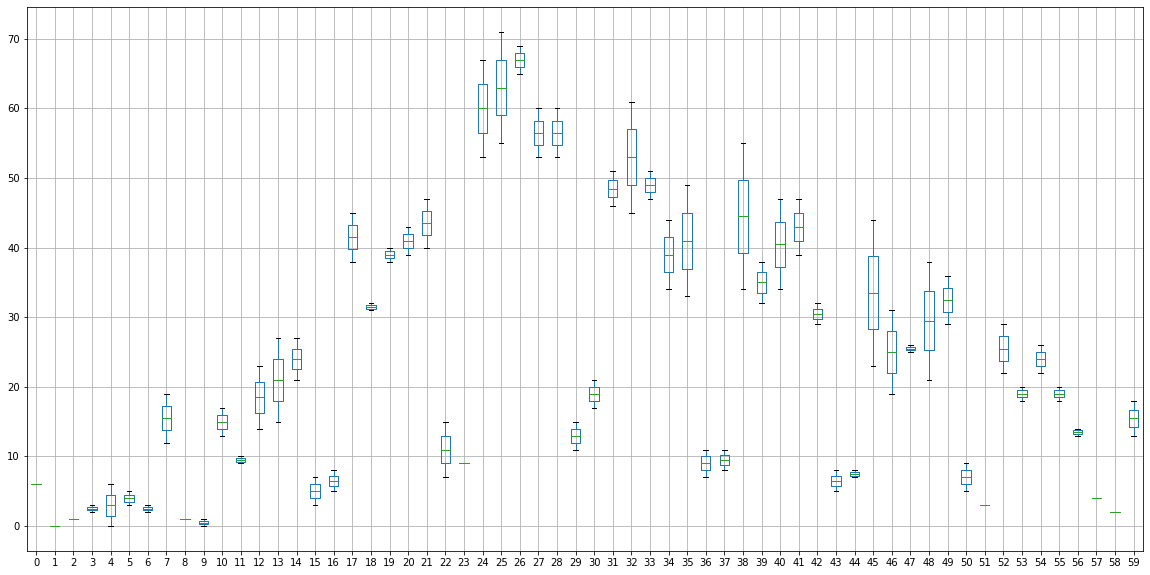

In [194]:
cases_df.transpose().boxplot(figsize=(20,10))

There has to be an easier way to browse all results

In [105]:
import pickle

file_name = '/src/experiments/validation/results/data/0x323219c230079382f2af0c132c1e4294/sim_v2_people-3000_days-60_init-0.002_uptake--1_seed-189_20210703-151918_225800/tracker_data_n_3000_seed_189_20210703-152928.pkl'
with open(file_name, 'rb') as results_file:
    tracker = pickle.load(results_file)
tracker.keys()

dict_keys(['intervention_day', 'intervention', 'risk_model', 'COVID_SPREAD_START_TIME', 'INTERVENTION_START_TIME', 'SIMULATION_START_TIME', 'simulation_days', 'n_humans', 'n_init_infected', 'adoption_rate', 'generation_times', 'p_transmission', 'age_histogram', 'human_has_app', 'known_connections', 'humans_demographics', 'contact_patterns', 'infectious_contact_patterns', 'expected_mobility', 'mobility', 'infection_monitor', 'outside_daily_contacts', 'effective_contacts_since_intervention', 'healthy_effective_contacts_since_intervention', 'effective_contacts_all_days', 'healthy_effective_contacts_all_days', 'serial_interval', 'all_serial_intervals', 'cases_per_day', 'ei_per_day', 's', 'e', 'i', 'r', 'avg_infectiousness_per_day', 'covid_properties', 'recovered_stats', 'symptoms', 'test_monitor', 'risk_precision_global', 'risk_precision', 'human_monitor', 'infector_infectee_update_messages', 'risk_attributes', 'humans_state', 'humans_rec_level', 'humans_intervention_level', 'to_human_max_